## lasso回归
- 使用L1 正则化项的线性回归

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#### 因为Lasso的代价函数并非处处可导，所以梯度下降可能无法达到全局最优解，可使用坐标下降法或者最小角回归方法来实现Lasso的训练

### 梯度下降法

In [2]:
class LassoRegression(object):
    def __init__(self, learning_rate = 0.1, epochs = 500, verbose=False, lam=0.5):
        self.theta = None
        self.b = None
        self.alpha = learning_rate
        self.epochs = epochs
        self.verbose = verbose
        self.lam = lam
    def train(self, train_x, train_y):
        if len(train_y.shape) == 1:
            train_y = train_y.reshape(-1, 1)
        m , n = train_x.shape
        np.random.seed(78)
        mu = 0.4
        sigma = 0.8
        self.theta = sigma*np.random.randn(1,n)+mu
        self.b = np.random.random()
        for i in xrange(self.epochs):
            pre_y = self.predict(train_x)
            delta_l1 = np.ones_like(self.theta)
            delta_l1[self.theta < 0] = -1
            d_theta = np.mean((pre_y - train_y)*train_x,axis=0) \
                                                + self.lam * delta_l1
            d_b    = np.mean(pre_y - train_y, axis=0)
            self.theta -= self.alpha * d_theta
            self.b     -= self.alpha * d_b
            if self.verbose is True and (i+1) % 100 == 0:
                print "the %d epoch, the W is %d and the b is %d" \
                % (i, self.theta, self.b)
    def fit(self, train_x, train_y):
        self.train(train_x, train_y)
    def predict(self, x):
        """
        type sita:([[]])
        type b:float
        type X:([[]])
        rtype:([[]])
        """
        pre = np.dot(x , self.theta.T) + self.b
        return pre

### 坐标下降法

In [23]:
class LassoRegression1(object):
    def __init__(self, learning_rate = 0.01, epochs = 500, verbose=False, lam=0.5,
                 epsilon=1e-7):
        self.theta = None
        self.b = None
        self.alpha = learning_rate
        self.epochs = epochs
        self.verbose = verbose
        self.lam = lam
        self.epsilon = epsilon
    def train(self, train_x, train_y):
        if len(train_y.shape) == 1:
            train_y = train_y.reshape(-1, 1)
        m , n = train_x.shape
        np.random.seed(78)
        mu = 0.4
        sigma = 0.8
        self.theta = sigma*np.random.randn(1,n)+mu
        self.b = np.random.random()
        i = 0
        while i < self.epochs:
            axis_updates = 0 # 发生更新的坐标轴个数
            cur_axis_updates = 0 # 当前坐标轴的更新次数
            # 先更新b
            while True:
                pre_y = self.predict(train_x)
                d_b   = np.mean(pre_y - train_y, axis=0)
                b_update = self.alpha * d_b
                if np.abs(b_update) < self.epsilon:
                    break
                self.b -= b_update
                cur_axis_updates += 1
            if cur_axis_updates > 0:
                axis_updates += 1
            # 按照坐标顺序依次更新w
            for j in range(n):
                cur_axis_updates = 0 # 重新归零
                while cur_axis_updates < 50: # 内部迭代次数的限制
                    pre_y = self.predict(train_x)
                    delta_l1 = 0
                    if self.theta[0][j] > 0:
                        delta_l1 = 1
                    elif self.theta[0][j] < 0:
                        delta_l1 = -1
                    d_theta = np.mean((pre_y - train_y)*train_x[:, j].reshape(-1, 1)) \
                                                    + self.lam * delta_l1
                    theta_update = self.alpha * d_theta
                    if np.abs(theta_update) < self.epsilon:
                        break
                    self.theta[0][j] -= theta_update
                    cur_axis_updates += 1
                if cur_axis_updates > 0:
                    axis_updates += 1
            if self.verbose is True and (i+1) % 50 == 0:
                print "the %d epoch" % (i+1)
            if axis_updates == 0: # 说明没有坐标轴的更新量大于阈值，退出外部循环即可
                break
            i += 1
    def fit(self, train_x, train_y):
        self.train(train_x, train_y)
    def predict(self, x):
        """
        type sita:([[]])
        type b:float
        type X:([[]])
        rtype:([[]])
        """
        pre = np.dot(x , self.theta.T) + self.b
        return pre

### 最小角回归方法 
- 待续

In [17]:
def load_data():
    n_samples, n_features = 50, 200
    X = np.random.randn(n_samples, n_features)
    coef = 3 * np.random.randn(n_features)
    inds = np.arange(n_features)
    np.random.shuffle(inds)
    coef[inds[10:]] = 0  # sparsify coef
    y = np.dot(X, coef)

    # add noise
    y += 0.01 * np.random.normal(size=n_samples)

    # Split data in train set and test set
    n_samples = X.shape[0]
    X_train, y_train = X[:n_samples // 2], y[:n_samples // 2]
    X_test, y_test = X[n_samples // 2:], y[n_samples // 2:]
    
    return X_train, X_test, y_train, y_test, coef

In [18]:
def regression(train_x, train_y, test_x, test_y, coef):
    lam = 0.2
    lasso = LassoRegression1(learning_rate=0.1, epochs=500, verbose=True, lam=lam,
                             epsilon=1e-2)
    lasso.fit(train_x, train_y)
    y_pre = lasso.predict(test_x)
    r2_score_lasso = r2_score(test_y, y_pre)
    print("r^2 on test data : %f" % r2_score_lasso)

    plt.figure(figsize=(12, 7))
    plt.plot(lasso.theta.flatten(), color='gold', linewidth=2, label='Lasso coefficients')
    plt.plot(coef, '--', color='navy', label='original coefficients')
    plt.legend(loc='best')
    plt.title("Lasso R^2: %f" % (r2_score_lasso))

In [19]:
train_x, test_x, train_y, test_y, coef = load_data()

In [20]:
print train_x.shape
print test_x.shape

(25, 200)
(25, 200)


the 50 epoch
the 100 epoch
the 150 epoch
the 200 epoch
the 250 epoch
the 300 epoch
the 350 epoch
the 400 epoch
the 450 epoch
the 500 epoch
r^2 on test data : 0.694874


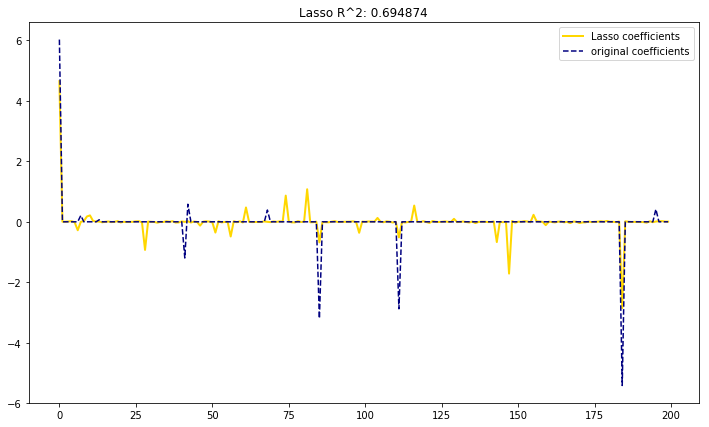

In [24]:
regression(train_x, train_y, test_x, test_y, coef)